In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 8)


In [2]:
import os
# os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"  # makes some CUDA calls deterministic
import torch
torch.use_deterministic_algorithms(True)
# torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.set_grad_enabled(False)
torch.inference_mode(True)


In [3]:
from typing import NamedTuple, List, Dict, Optional
from tqdm.notebook import tqdm
import random
import csv
from collections import defaultdict


In [4]:

def load_rows():
  src = '../stats/results_raw.csv'
  rows = []
  with open(src, newline='') as f:
    reader = csv.DictReader(f)
    for row in reader:
      rows.append(row)
  return rows


CSV_rows = load_rows()


In [5]:

def is_number(s: str) -> bool:
  try:
    _ = float(s)
    return True
  except ValueError:
    return False

def is_integer(s: str) -> bool:
  try:
    f = float(s)
    return f.is_integer()
  except ValueError:
    return False

def as_int(s: str) -> int:
  try:
    return int(s)
  except ValueError:
    return int(float(s))

def get_labels_and_data(rows):
  # keep track of things
  str_to_id = {}  # map from strings to int ids used to represent them
  strs = []
  non_num_cols = set()  # names of columns with at least one non-numeric entry
  non_int_cols = set()  # names of columns with at least one non-integer entry
  str_data = defaultdict(list)
  # parse each row, save list of str for each col
  for row in tqdm(rows):
    for k,v in row.items():
      str_data[k].append(v)
      if is_integer(v):
        continue
      non_int_cols.add(k)
      if is_number(v):
        continue
      non_num_cols.add(k)
      if v not in str_to_id:
        str_to_id[v] = len(str_to_id)
        strs.append(v)
  # convert number lists to tensors
  tensors = {}
  for k, strlist in str_data.items():
    if k in non_num_cols:
      tensors[k] = torch.tensor([str_to_id[v] for v in strlist], dtype=torch.short)
    elif k in non_int_cols:
      tensors[k] = torch.tensor([float(v) for v in strlist], dtype=torch.float)
    else:
      tensors[k] = torch.tensor([as_int(v) for v in strlist], dtype=torch.long)
  # augment
  tensors['K'] = tensors['G'] / (tensors['N'] * tensors['D'])
  return tuple(strs), tensors


labels, data = get_labels_and_data(CSV_rows)
n = len(CSV_rows)


  0%|          | 0/6022 [00:00<?, ?it/s]

In [6]:

print('labels:', labels)
print('str cols:', [k for k,v in data.items() if v.dtype == torch.short])
print('int cols:', [k for k,v in data.items() if v.dtype == torch.long])
print('float cols:', [k for k,v in data.items() if v.dtype == torch.float])


labels: ('0823_greece', 'simple', 'sinc', 'adam', 'tpc', '0872_walnuts', '0801_penguin', '0809_lion', '0887_castle', 'complex', 'rect', 'tri', 'gauss', 's0823_greece')
str cols: ['sig', 'type', 'gen', 'opt']
int cols: ['D', 'N', 'H', 'G', 'seed', 'mlr', 'epoch_count', 'P', 'last_epoch', 'best_epoch', 'worst_epoch', 'time_min', 'time_max', 'time_total', 'I']
float cols: ['last_mse', 'best_mse', 'worst_mse', 'K']


In [7]:

def narrow(srcdata, reqs: Dict) -> Dict:
  mask = torch.ones_like(srcdata['D'], dtype=torch.bool)
  for k, v in reqs.items():
    if type(v) is str:
      v = labels.index(v)
    mask = mask & (srcdata[k] == torch.full_like(srcdata[k], v))
  narrowed = {}
  for k, v in srcdata.items():
    narrowed[k] = v[mask]
  return narrowed

def summarise(srcdata):
  colnames = ['D', 'sig', 'type', 'gen', 'N', 'H', 'G', 'opt', 'seed']
  for colname in colnames:
    line = colname + ':    '
    t = srcdata[colname]
    counts = torch.bincount(t)
    for i in range(100):
      res = torch.max(counts, dim=0)
      val = res.values.item()
      ind = res.indices.item()
      if val == 0:
        break
      rep = ind if t.dtype != torch.short else labels[ind]
      line += f'{rep} (x{val})  '
      counts[ind] = 0
      if len(line) > 100:
        line += ' ...'
        break
    print(line)

summarise(data)


D:    2 (x3254)  1 (x2768)  
sig:    0823_greece (x1962)  0801_penguin (x884)  0809_lion (x881)  0872_walnuts (x874)  0887_castle (x874)   ...
type:    simple (x6010)  complex (x12)  
gen:    sinc (x5890)  rect (x44)  tri (x44)  gauss (x44)  
N:    8 (x467)  10 (x450)  5 (x414)  2 (x400)  4 (x394)  3 (x384)  9 (x345)  7 (x322)  6 (x321)  20 (x296)   ...
H:    1 (x2530)  0 (x1599)  2 (x717)  4 (x323)  3 (x189)  5 (x170)  8 (x160)  6 (x153)  7 (x119)  9 (x32)   ...
G:    1 (x2204)  2 (x690)  3 (x620)  4 (x392)  5 (x361)  10 (x295)  6 (x249)  8 (x183)  9 (x167)  7 (x160)   ...
opt:    adam (x4562)  tpc (x1460)  
seed:    0 (x2996)  1 (x1275)  2 (x1134)  3 (x170)  4 (x87)  5 (x47)  6 (x29)  7 (x27)  8 (x26)  9 (x26)   ...


D:    1 (x2768)  
sig:    0823_greece (x1020)  0801_penguin (x440)  0809_lion (x438)  0872_walnuts (x435)  0887_castle (x435)   ...
type:    simple (x2768)  
gen:    sinc (x2768)  
N:    20 (x260)  2 (x142)  3 (x132)  5 (x132)  10 (x131)  4 (x105)  40 (x104)  6 (x94)  7 (x90)  8 (x90)   ...
H:    0 (x1452)  1 (x919)  2 (x123)  4 (x94)  8 (x38)  3 (x27)  5 (x25)  7 (x23)  9 (x23)  6 (x22)  10 (x22)   ...
G:    1 (x1587)  2 (x172)  3 (x162)  5 (x162)  4 (x135)  20 (x118)  10 (x108)  6 (x71)  16 (x55)  25 (x39)   ...
opt:    adam (x2330)  tpc (x438)  
seed:    0 (x1764)  1 (x372)  2 (x359)  3 (x19)  4 (x19)  5 (x19)  6 (x19)  7 (x19)  8 (x19)  9 (x19)   ...


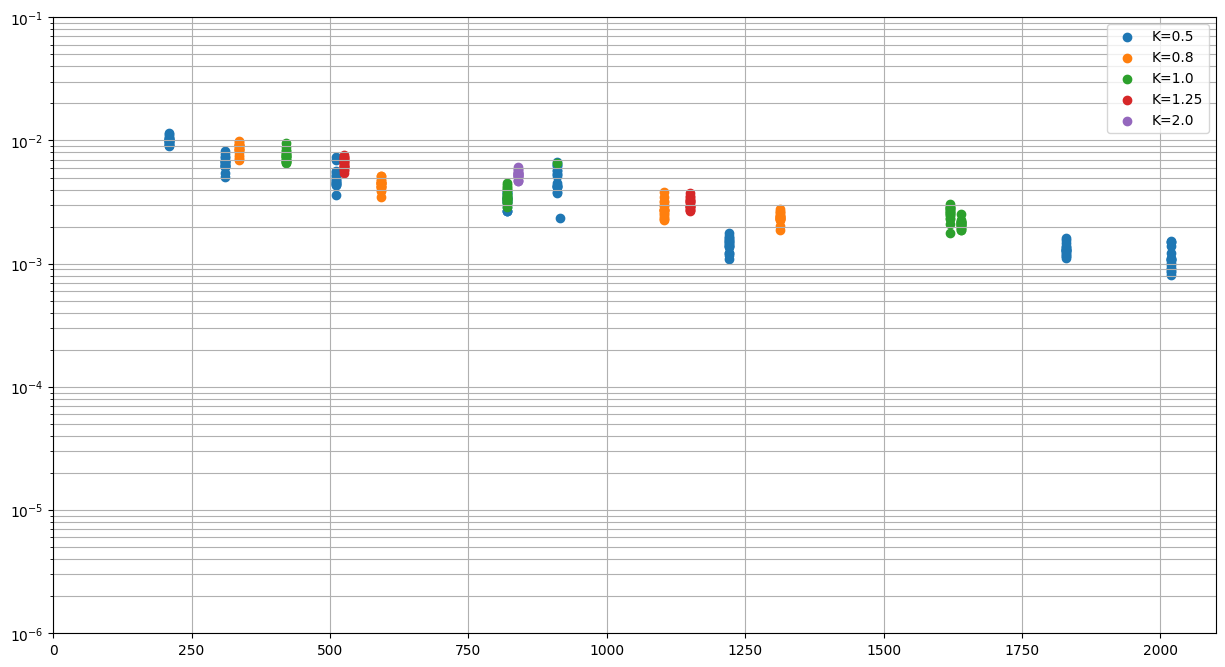

In [8]:

data_1d = narrow(data, {'D': 1})
summarise(data_1d)
d = narrow(data_1d, {'sig': '0823_greece', 'gen': 'sinc'})
# d_lstsq = narrow(d, {'opt': 'lstsq'})
d_tpc = narrow(d, {'opt': 'tpc'})

fig, ax = plt.subplots(nrows=1)
# ax.scatter(d_lstsq['P'], d_lstsq['best_mse'], label='lstsq')
for kpct in [50, 80, 100, 125, 200]:
  kv = kpct/100
  d_k = narrow(d_tpc, {'K': kv})
  ax.scatter(d_k['P'], d_k['best_mse'], label=f'K={kv}')

ax.set_yscale('log')
ax.set_ylim(1e-6, 1e-1)
# ax.set_xscale('log')
ax.set_xlim(0, 2100)
ax.grid(which='both')
ax.legend()



D:    2 (x3254)  
sig:    0823_greece (x942)  s0823_greece (x547)  0801_penguin (x444)  0809_lion (x443)  0872_walnuts (x439)   ...
type:    simple (x3242)  complex (x12)  
gen:    sinc (x3122)  rect (x44)  tri (x44)  gauss (x44)  
N:    8 (x377)  10 (x319)  4 (x289)  5 (x282)  2 (x258)  9 (x255)  3 (x252)  7 (x232)  6 (x227)  12 (x122)   ...
H:    1 (x1611)  2 (x594)  4 (x229)  3 (x162)  0 (x147)  5 (x145)  6 (x131)  8 (x122)  7 (x96)  9 (x9)   ...
G:    1 (x617)  2 (x518)  3 (x458)  4 (x257)  5 (x199)  10 (x187)  6 (x178)  8 (x164)  7 (x148)  9 (x148)   ...
opt:    adam (x2232)  tpc (x1022)  
seed:    0 (x1232)  1 (x903)  2 (x775)  3 (x151)  4 (x68)  5 (x28)  6 (x10)  7 (x8)  8 (x7)  9 (x7)   ...


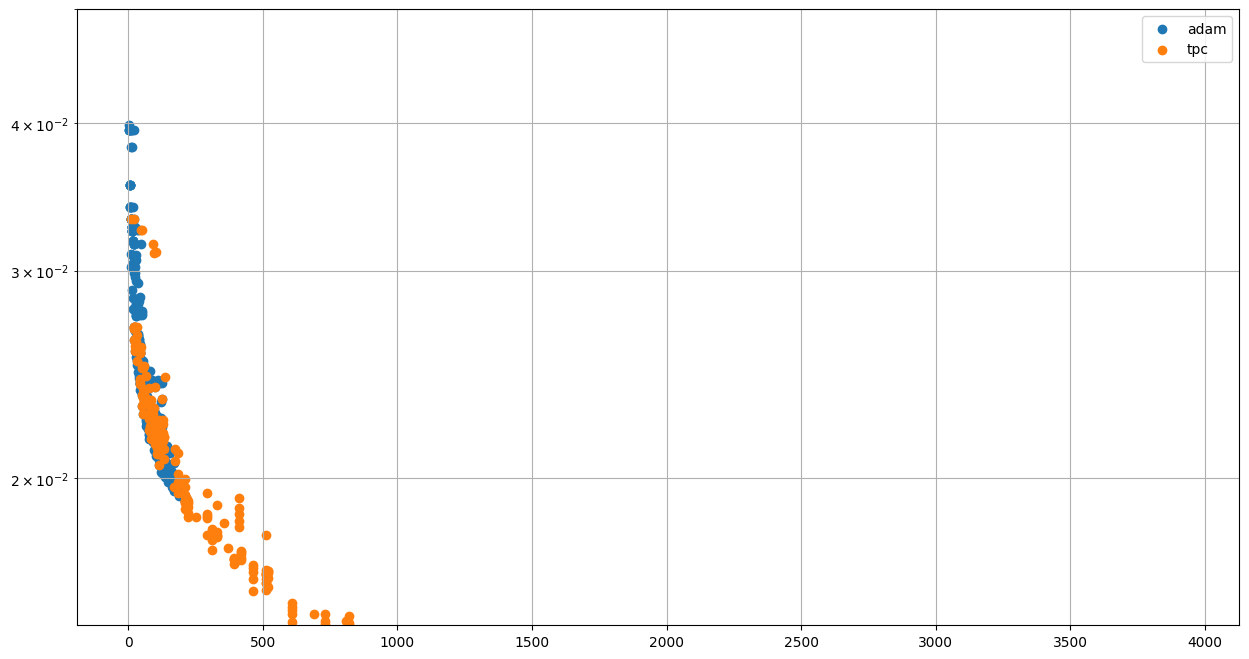

In [9]:

data_2d = narrow(data, {'D': 2})
summarise(data_2d)
d = narrow(data_2d, {'sig': '0823_greece', 'gen': 'sinc'})
# d_lstsq = narrow(d, {'opt': 'lstsq'})
d_adam = narrow(d, {'opt': 'adam'})
d_tpc = narrow(d, {'opt': 'tpc'})

fig, ax = plt.subplots(nrows=1)
# for h in range(10):
#   s = narrow(d, {'H': h})
#   ax.scatter(s['P'], s['best_mse'], c=s['N'], label=f'H={h}')
ax.scatter(d_adam['P'], d_adam['best_mse'], label='adam')
# ax.scatter(d_lstsq['P'], d_lstsq['best_mse'], label='lstsq')
ax.scatter(d_tpc['P'], d_tpc['best_mse'], label='tpc')

ax.set_yscale('log')
ax.set_ylim(1.5e-2, 5e-2)
# ax.set_xscale('log')
# ax.set_xlim(0, 200)
ax.grid(which='both')
ax.legend()



In [10]:

# data_1d_sinc_lstsq = narrow(data_1d, {'gen': 'tri', 'opt': 'lstsq'})
# fig, ax = plt.subplots(nrows=1)
# penguin = narrow(data_1d_sinc_lstsq, {'sig': '0801_penguin'})
# lion = narrow(data_1d_sinc_lstsq, {'sig': '0809_lion'})
# greece = narrow(data_1d_sinc_lstsq, {'sig': '0823_greece'})
# walnuts = narrow(data_1d_sinc_lstsq, {'sig': '0872_walnuts'})
# castle = narrow(data_1d_sinc_lstsq, {'sig': '0887_castle'})
# ax.scatter(penguin['P'], penguin['best_mse'], label='penguin')
# ax.scatter(lion['P'], lion['best_mse'], label='lion')
# ax.scatter(greece['P'], greece['best_mse'], label='greece')
# ax.scatter(walnuts['P'], walnuts['best_mse'], label='walnuts')
# ax.scatter(castle['P'], castle['best_mse'], label='castle')
# ax.set_yscale('log')
# ax.set_ylim(1e-8, 1e-1)
# # ax.set_xscale('log')
# ax.set_xlim(0, 2100)
# ax.grid(which='both')
# ax.legend()


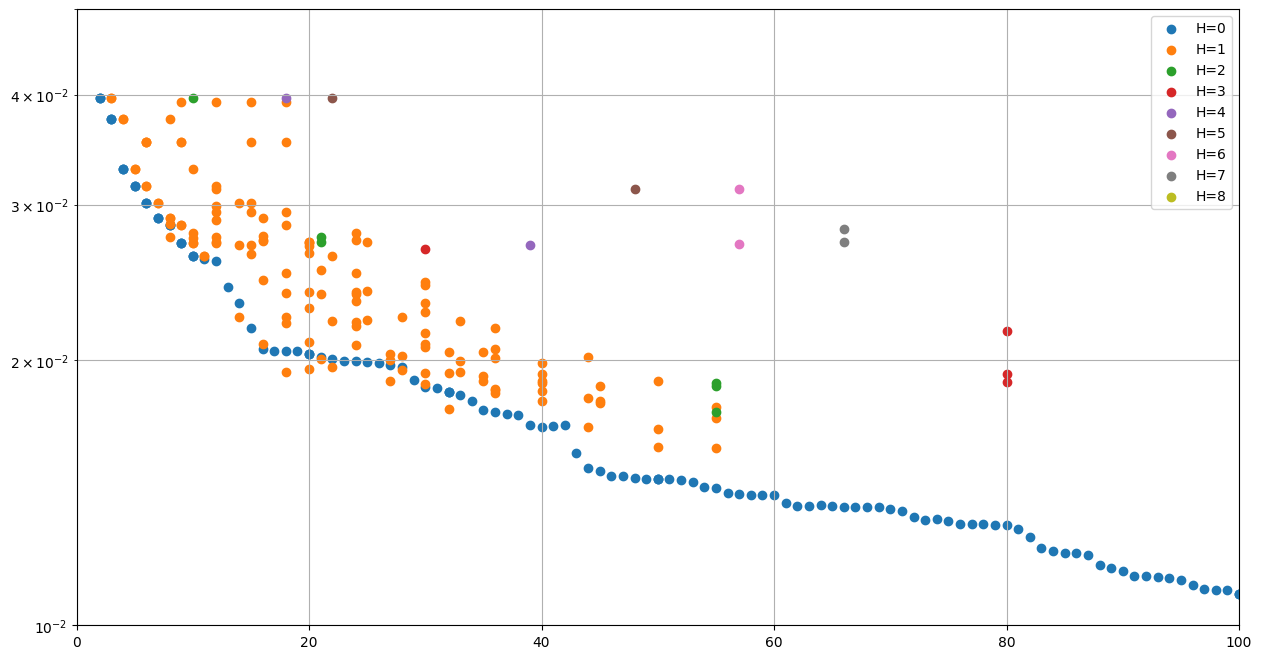

In [11]:

k1data = narrow(data, {'D': 1, 'sig': '0823_greece'})
k1inds = k1data['G'] == k1data['G']
for k in list(k1data.keys()):
  k1data[k] = k1data[k][k1inds]
depths = [narrow(data, {'D': 1, 'sig': '0823_greece', 'H': 0})]
for i in range(1, 8+1):
  depths.append(narrow(k1data, {'H': i}))

fig, ax = plt.subplots(nrows=1)
for i, d in enumerate(depths):
  ax.scatter(d['P'], d['best_mse'], label=f'H={i}')
ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_ylim(0.01, 0.05)
ax.set_xlim(0, 100)
ax.grid(which='both')
ax.legend()




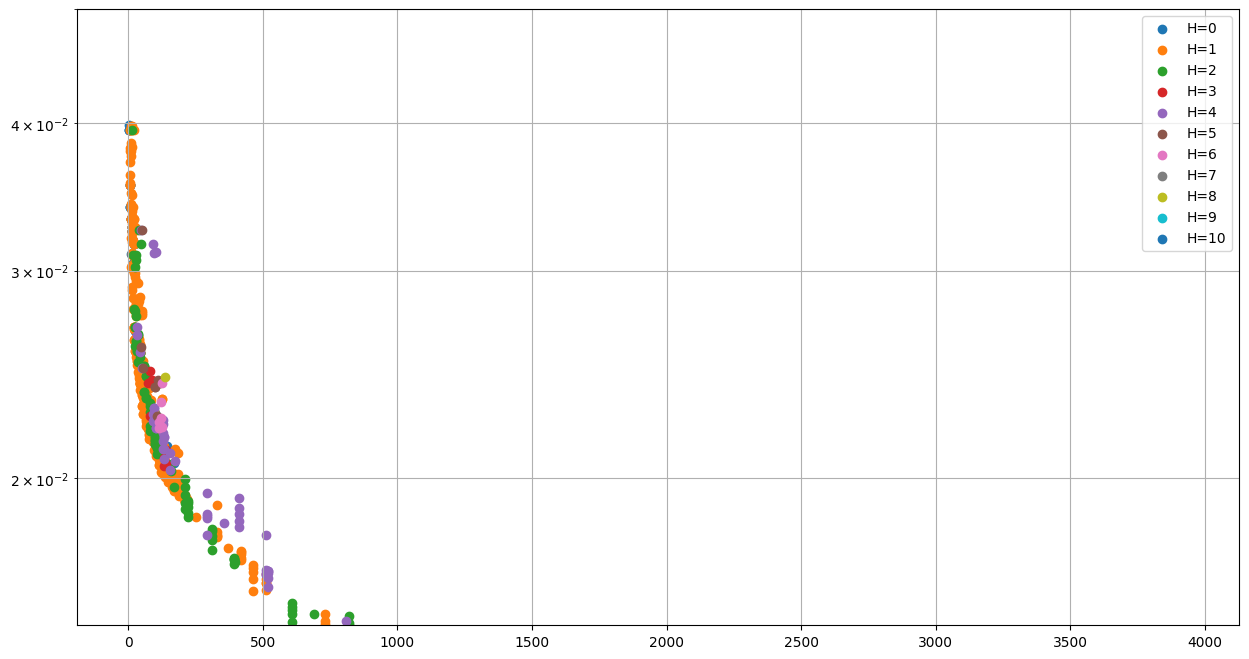

In [12]:

data_2d_greece = narrow(data_2d, {'sig': '0823_greece'})
fig, ax = plt.subplots(nrows=1)
for h in range(10+1):
  subset = narrow(data_2d_greece, {'H': h})
  ax.scatter(subset['P'], subset['best_mse'], label=f'H={h}')
ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_ylim(0.015, 0.05)
# ax.set_xlim(0, 100)
ax.grid(which='both')
ax.legend()


In [13]:
summarise(narrow(data_2d_greece, {'H': 0}))


D:    2 (x39)  
sig:    0823_greece (x39)  
type:    simple (x27)  complex (x12)  
gen:    sinc (x39)  
N:    2 (x4)  3 (x4)  4 (x4)  5 (x4)  6 (x4)  7 (x4)  8 (x4)  9 (x4)  10 (x4)  11 (x1)  12 (x1)  13 (x1)   ...
H:    0 (x39)  
G:    1 (x39)  
opt:    adam (x39)  
seed:    0 (x21)  1 (x9)  2 (x9)  
